In [1]:
import pandas as pd
import numpy as np
import random
import os, pickle5 as pickle, json, requests

from datasets import load_dataset, load_from_disk
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM
import torch

In [3]:
data_files = [
  "/gpfs/data/geraslab/Jan/data/rad_reports/2022.01.combined_rad_reports/ultrasound.xlsx",
  "/gpfs/data/geraslab/Jan/data/rad_reports/2022.01.combined_rad_reports/MRI.xlsx",
  "/gpfs/data/geraslab/Jan/data/rad_reports/2022.01.combined_rad_reports/MG.pkl",
]
report_path = "/gpfs/data/geraslab/ekr6072/projects/study_indication/data/mlm_dataset"

In [4]:
def load_data(path):
  path = Path(path)
  if path.suffix == ".xlsx":
    data = pd.read_excel(path, engine='openpyxl', index_col=0)
    return data
  elif path.suffix == ".pkl":
    with open(path, 'rb') as f:
      data = pickle.load(f)
    return data

In [29]:
# TODO: log Acc in train and test set
all_data = []
all_acns = []
for data_file in data_files:
    data = load_data(data_file)
    data = data.drop_duplicates(subset='Acc', keep='first')
    column = list({'RawReport', 'Report'}.intersection(data.columns))
    assert len(column) == 1, 'invalid number of matching columns'
    column = column[0]
    acns = list(data['Acc'].values)
    data = list(data[column].values)
    all_data.extend(data)
    all_acns.extend(acns)
assert len(all_acns) == len(all_data), "acn list and report list have mismatch lengths"

text_data = []
acn_data = []
for acn, data in zip(acns, all_data):
    if isinstance(data, str):
        text_data.append(data)
        acn_data.append(acn)
del all_data
del all_acns


In [31]:
df = pd.DataFrame({'text': text_data, 'acn': acn_data})

In [40]:
from datasets import Dataset
dataset = Dataset.from_pandas(df)

In [4]:
tokenizer = AutoTokenizer.from_pretrained("yikuan8/Clinical-Longformer")

In [5]:
model = AutoModelForMaskedLM.from_pretrained("yikuan8/Clinical-Longformer")

In [44]:
def tokenize_and_chunk(texts):
  return tokenizer(
                  texts["text"],
                  truncation=True,
                  max_length=1024,
                  return_overflowing_tokens=True
                  )

In [45]:
tokenized_datasets = dataset.map(tokenize_and_chunk, batched=True, remove_columns=["text", "acn"])

  0%|          | 0/1169 [00:00<?, ?ba/s]

In [23]:
# tokenized_datasets.save_to_disk(report_path)
# tokenized_datasets = load_from_disk(report_path)

In [24]:
tokenized_datasets

Dataset({
    features: ['input_ids', 'attention_mask', 'overflow_to_sample_mapping'],
    num_rows: 1808534
})

In [25]:
dataset = tokenized_datasets.train_test_split(test_size=5000)

In [6]:
# dataset.save_to_disk(report_path)
dataset = load_from_disk(report_path)

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'overflow_to_sample_mapping'],
        num_rows: 1803321
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'overflow_to_sample_mapping'],
        num_rows: 5000
    })
})

In [8]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

In [10]:
lengths = []
for data in dataset['train']:
  length = len(data['input_ids'])
  lengths.append(length)

KeyboardInterrupt: 

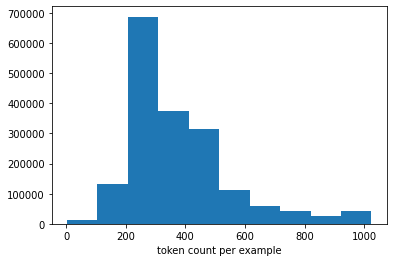

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist(lengths, bins=10);
ax.set_xlabel('token count per example');

In [14]:
print(f"total tokens = {sum(lengths)}")
print(f"avg tokens per sample = {sum(lengths) / len(lengths)}")
print(f"total number of samples = {len(lengths)}")

total tokens = 677652230
avg tokens per sample = 375.78014674037513
total number of samples = 1803321


In [11]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./models",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=1000,
    logging_strategy="steps",
    logging_steps=1,
    logging_first_step=True,
    save_strategy="steps",
    save_steps=2000,
    evaluation_strategy = "steps",
    eval_steps=2000,
    learning_rate=2e-5,
    weight_decay=0.01,
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test']
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend


In [12]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `LongformerForMaskedLM.forward` and have been ignored: overflow_to_sample_mapping. If overflow_to_sample_mapping are not expected by `LongformerForMaskedLM.forward`,  you can safely ignore this message.
/gpfs/data/geraslab/ekr6072/miniconda3/envs/ds_1012/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1803321
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 48
  Gradient Accumulation steps = 1
  Total optimization steps = 37570


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/gpfs/data/geraslab/ekr6072/miniconda3/envs/ds_1012/lib/python3.6/site-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/gpfs/data/geraslab/ekr6072/miniconda3/envs/ds_1012/lib/python3.6/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/gpfs/data/geraslab/ekr6072/miniconda3/envs/ds_1012/lib/python3.6/site-packages/transformers/models/longformer/modeling_longformer.py", line 1807, in forward
    return_dict=return_dict,
  File "/gpfs/data/geraslab/ekr6072/miniconda3/envs/ds_1012/lib/python3.6/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/gpfs/data/geraslab/ekr6072/miniconda3/envs/ds_1012/lib/python3.6/site-packages/transformers/models/longformer/modeling_longformer.py", line 1714, in forward
    return_dict=return_dict,
  File "/gpfs/data/geraslab/ekr6072/miniconda3/envs/ds_1012/lib/python3.6/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/gpfs/data/geraslab/ekr6072/miniconda3/envs/ds_1012/lib/python3.6/site-packages/transformers/models/longformer/modeling_longformer.py", line 1296, in forward
    output_attentions=output_attentions,
  File "/gpfs/data/geraslab/ekr6072/miniconda3/envs/ds_1012/lib/python3.6/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/gpfs/data/geraslab/ekr6072/miniconda3/envs/ds_1012/lib/python3.6/site-packages/transformers/models/longformer/modeling_longformer.py", line 1220, in forward
    output_attentions=output_attentions,
  File "/gpfs/data/geraslab/ekr6072/miniconda3/envs/ds_1012/lib/python3.6/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/gpfs/data/geraslab/ekr6072/miniconda3/envs/ds_1012/lib/python3.6/site-packages/transformers/models/longformer/modeling_longformer.py", line 1156, in forward
    output_attentions=output_attentions,
  File "/gpfs/data/geraslab/ekr6072/miniconda3/envs/ds_1012/lib/python3.6/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/gpfs/data/geraslab/ekr6072/miniconda3/envs/ds_1012/lib/python3.6/site-packages/transformers/models/longformer/modeling_longformer.py", line 584, in forward
    query_vectors, key_vectors, self.one_sided_attn_window_size
  File "/gpfs/data/geraslab/ekr6072/miniconda3/envs/ds_1012/lib/python3.6/site-packages/transformers/models/longformer/modeling_longformer.py", line 827, in _sliding_chunks_query_key_matmul
    diagonal_chunked_attention_scores = torch.einsum("bcxd,bcyd->bcxy", (query, key))  # multiply
  File "/gpfs/data/geraslab/ekr6072/miniconda3/envs/ds_1012/lib/python3.6/site-packages/torch/functional.py", line 342, in einsum
    return einsum(equation, *_operands)
  File "/gpfs/data/geraslab/ekr6072/miniconda3/envs/ds_1012/lib/python3.6/site-packages/torch/functional.py", line 344, in einsum
    return _VF.einsum(equation, operands)  # type: ignore
RuntimeError: CUDA out of memory. Tried to allocate 144.00 MiB (GPU 0; 22.38 GiB total capacity; 21.38 GiB already allocated; 120.06 MiB free; 21.62 GiB reserved in total by PyTorch)


In [ ]:
trainer.save_model("./EsperBERTo")